In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [3]:
import zipfile
dataset_path = "/content/combined_dataset.zip"
extract_path = "/content/cv_dataset"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted successfully at:", extract_path)


✅ Dataset extracted successfully at: /content/cv_dataset


In [4]:
def true_function(x):
    return np.sin(2*x) + 0.3*x

# True derivative
def true_derivative(x):
    return 2*np.cos(2*x) + 0.3

# Create synthetic dataset
x = np.linspace(-3, 3, 600)
y = true_function(x)
dy = true_derivative(x)

# Reshape
x = x.reshape(-1,1)
y = y.reshape(-1,1)
dy = dy.reshape(-1,1)

print("✅ Dataset created.")
print("X shape:", x.shape)
print("Y shape:", y.shape)
print("dY/dX shape:", dy.shape)



✅ Dataset created.
X shape: (600, 1)
Y shape: (600, 1)
dY/dX shape: (600, 1)


In [5]:
X_train, X_test, Y_train, Y_test, DY_train, DY_test = train_test_split(
    x, y, dy, test_size=0.2, random_state=42
)

# Convert to float32
X_train = X_train.astype("float32")
X_test  = X_test.astype("float32")
Y_train = Y_train.astype("float32")
Y_test  = Y_test.astype("float32")
DY_train = DY_train.astype("float32")
DY_test  = DY_test.astype("float32")

print("\n📊 Data split complete.")


📊 Data split complete.


In [6]:
def diff_loss(model, x, y_true, dy_true):
    """
    Differential Least Squares Loss
    L = (f(x) - y)^2 + 0.1 * (f'(x) - dy/dx)^2
    """

    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = model(x, training=True)
        dy_pred = tape.gradient(y_pred, x)

        loss_value = tf.reduce_mean((y_true - y_pred)**2)
        loss_deriv = tf.reduce_mean((dy_true - dy_pred)**2)

        total_loss = loss_value + 0.1 * loss_deriv

    return total_loss, loss_value, loss_deriv

In [7]:
def build_model():
    inputs = Input(shape=(1,))
    x = Dense(64, activation='tanh')(inputs)
    x = Dense(64, activation='tanh')(x)
    x = Dense(32, activation='tanh')(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

model = build_model()
optimizer = Adam(1e-3)

model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,401 (25.00 KB)

 Trainable params: 6,401 (25.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
print("\nℹ No augmentation required for 1D regression.")


# -----------------------------
# 6. Train Model (Custom Training Loop)
# -----------------------------
EPOCHS = 150
history_total = []
history_val = []
history_der = []

print("\n🚀 Training model...")

for epoch in range(EPOCHS):

    x_batch = tf.constant(X_train)
    y_batch = tf.constant(Y_train)
    dy_batch = tf.constant(DY_train)

    with tf.GradientTape() as tape:
        total_loss, val_loss, der_loss = diff_loss(model, x_batch, y_batch, dy_batch)

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    history_total.append(total_loss.numpy())
    history_val.append(val_loss.numpy())
    history_der.append(der_loss.numpy())

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Total={total_loss.numpy():.5f} | Value={val_loss.numpy():.5f} | Deriv={der_loss.numpy():.5f}")

print("\n✅ Training complete.")



ℹ No augmentation required for 1D regression.

🚀 Training model...
Epoch 20/150 | Total=0.42017 | Value=0.25836 | Deriv=1.61809
Epoch 40/150 | Total=0.20063 | Value=0.09048 | Deriv=1.10151
Epoch 60/150 | Total=0.17130 | Value=0.06678 | Deriv=1.04521
Epoch 80/150 | Total=0.16087 | Value=0.06365 | Deriv=0.97219
Epoch 100/150 | Total=0.15141 | Value=0.05978 | Deriv=0.91628
Epoch 120/150 | Total=0.14124 | Value=0.05510 | Deriv=0.86137
Epoch 140/150 | Total=0.12751 | Value=0.04939 | Deriv=0.78123

✅ Training complete.


In [9]:
# -----------------------------
Y_pred_test = model.predict(X_test)
mse = np.mean((Y_pred_test - Y_test)**2)

print(f"\n📉 Test MSE: {mse:.6f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step

📉 Test MSE: 0.064308


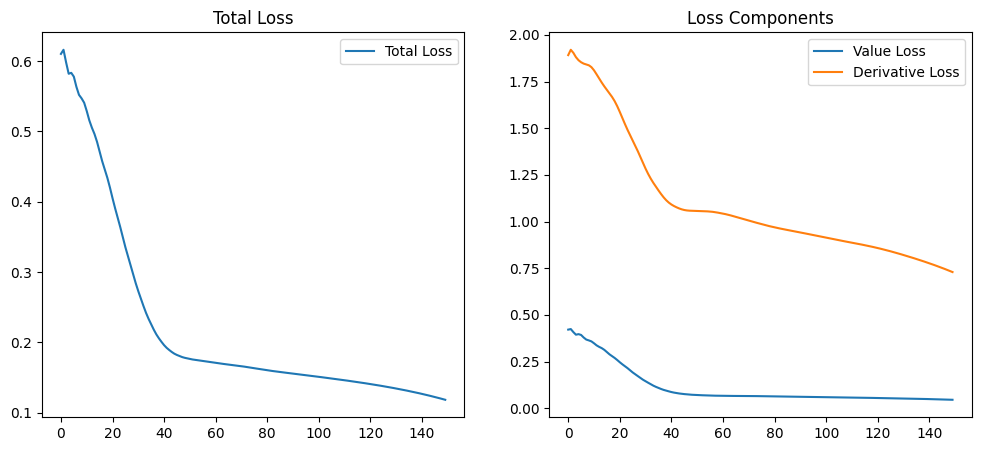

In [10]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_total, label='Total Loss')
plt.title("Total Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_val, label='Value Loss')
plt.plot(history_der, label='Derivative Loss')
plt.title("Loss Components")
plt.legend()

plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


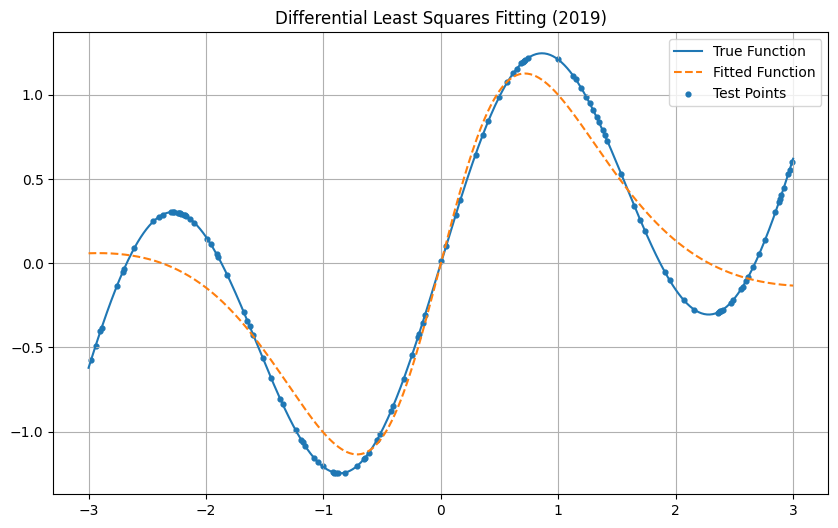

In [11]:
x_line = np.linspace(-3, 3, 500).reshape(-1,1)
y_true_line = true_function(x_line)
y_pred_line = model.predict(x_line)

plt.figure(figsize=(10,6))
plt.plot(x_line, y_true_line, label="True Function")
plt.plot(x_line, y_pred_line, '--', label="Fitted Function")
plt.scatter(X_test, Y_test, s=12, label="Test Points")
plt.grid()
plt.title("Differential Least Squares Fitting (2019)")
plt.legend()
plt.show()


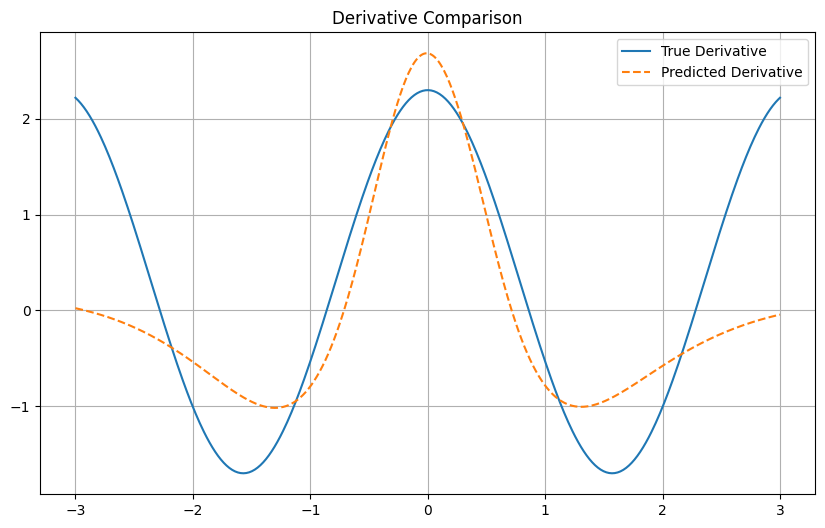

In [12]:
x_tf = tf.constant(x_line, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(x_tf)
    y_pred_tf = model(x_tf)
dy_pred_line = tape.gradient(y_pred_tf, x_tf)

dy_true_line = true_derivative(x_line)

plt.figure(figsize=(10,6))
plt.plot(x_line, dy_true_line, label="True Derivative")
plt.plot(x_line, dy_pred_line, '--', label="Predicted Derivative")
plt.grid()
plt.title("Derivative Comparison")
plt.legend()
plt.show()

In [13]:
print("\n🔍 Sample Predictions:")
for i in range(5):
    print(f"x={X_test[i][0]:.3f} | True y={Y_test[i][0]:.3f} | Pred y={Y_pred_test[i][0]:.3f}")


🔍 Sample Predictions:
x=-1.898 | True y=0.039 | Pred y=-0.204
x=1.197 | True y=1.039 | Pred y=0.822
x=2.659 | True y=-0.024 | Pred y=-0.098
x=-2.229 | True y=0.299 | Pred y=-0.044
x=-1.187 | True y=-1.051 | Pred y=-0.835


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


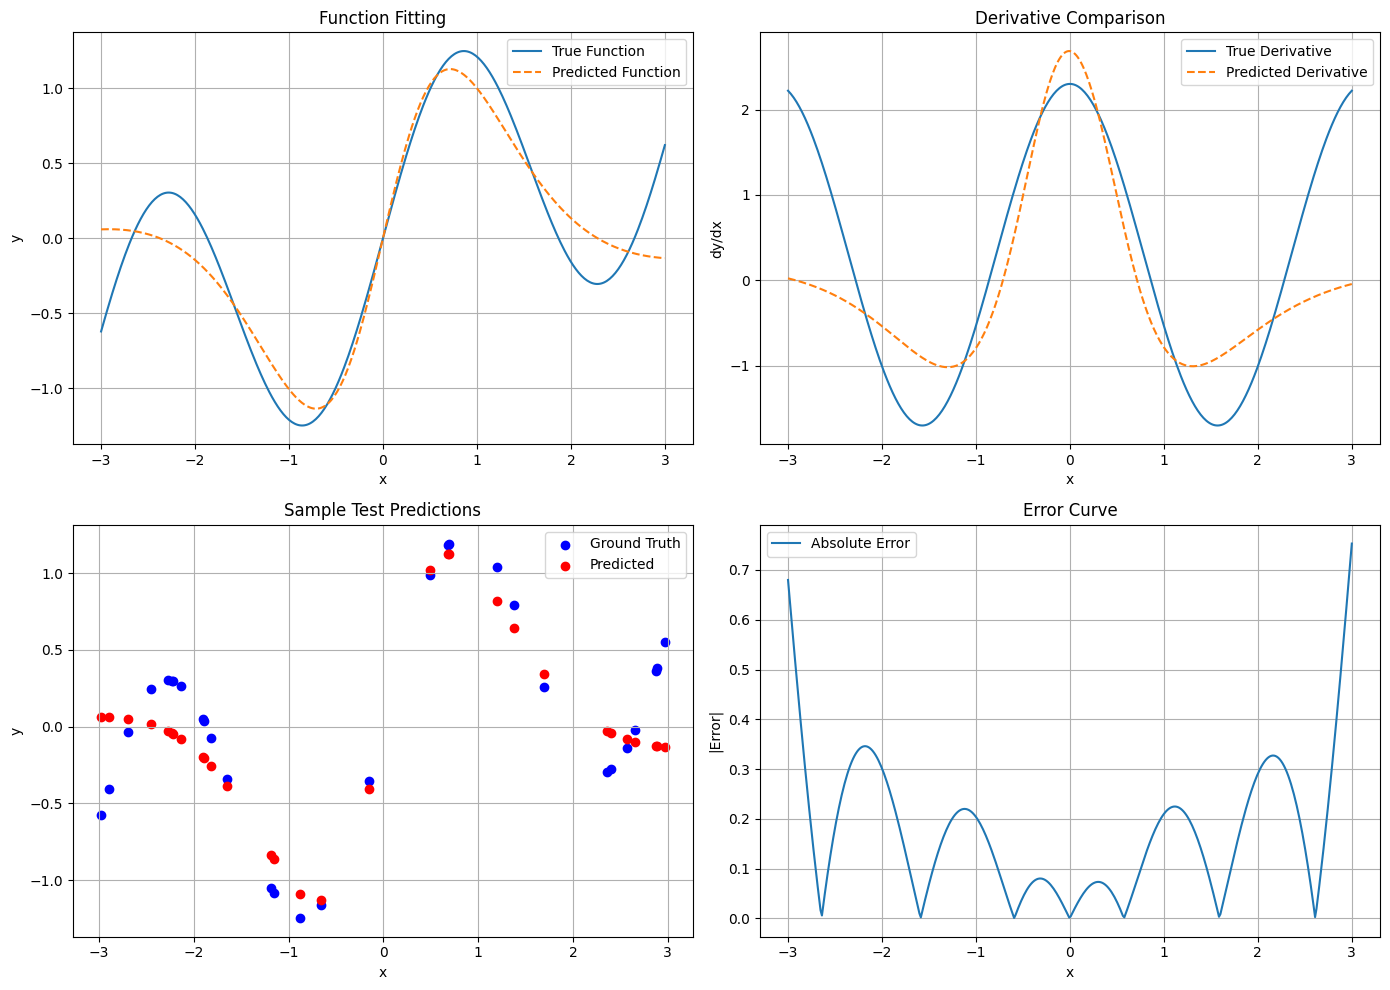


🔍 Sample Predictions (x, true y, predicted y):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
x=-1.898 | true=0.039 | pred=-0.204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
x=1.197 | true=1.039 | pred=0.822
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
x=2.659 | true=-0.024 | pred=-0.098
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
x=-2.229 | true=0.299 | pred=-0.044
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
x=-1.187 | true=-1.051 | pred=-0.835


In [14]:
# -----------------------------
# 11. Predict and Visualize Results
# -----------------------------

# Generate a smooth line for visualization
x_line = np.linspace(-3, 3, 400).reshape(-1, 1).astype("float32")

# True function and prediction
y_true_line = true_function(x_line)
y_pred_line = model.predict(x_line)

# True derivative and predicted derivative
x_tf = tf.constant(x_line, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(x_tf)
    y_pred_tf = model(x_tf)
dy_pred_line = tape.gradient(y_pred_tf, x_tf)

dy_true_line = true_derivative(x_line)

# ----- Plot Results -----
plt.figure(figsize=(14,10))

# 1. Fitted Function
plt.subplot(2,2,1)
plt.plot(x_line, y_true_line, label="True Function")
plt.plot(x_line, y_pred_line, '--', label="Predicted Function")
plt.title("Function Fitting")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")

# 2. Derivative Comparison
plt.subplot(2,2,2)
plt.plot(x_line, dy_true_line, label="True Derivative")
plt.plot(x_line, dy_pred_line, '--', label="Predicted Derivative")
plt.title("Derivative Comparison")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("dy/dx")

# 3. Show few test points (Original vs Predicted)
plt.subplot(2,2,3)
plt.scatter(X_test[:30], Y_test[:30], color='blue', label="Ground Truth")
plt.scatter(X_test[:30], model.predict(X_test[:30]), color='red', label="Predicted")
plt.title("Sample Test Predictions")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")

# 4. Error Plot
plt.subplot(2,2,4)
plt.plot(x_line, np.abs(y_true_line - y_pred_line), label="Absolute Error")
plt.title("Error Curve")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("|Error|")

plt.tight_layout()
plt.show()

print("\n🔍 Sample Predictions (x, true y, predicted y):")
for i in range(5):
    print(f"x={X_test[i][0]:.3f} | true={Y_test[i][0]:.3f} | pred={model.predict(X_test[i].reshape(1,1))[0][0]:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


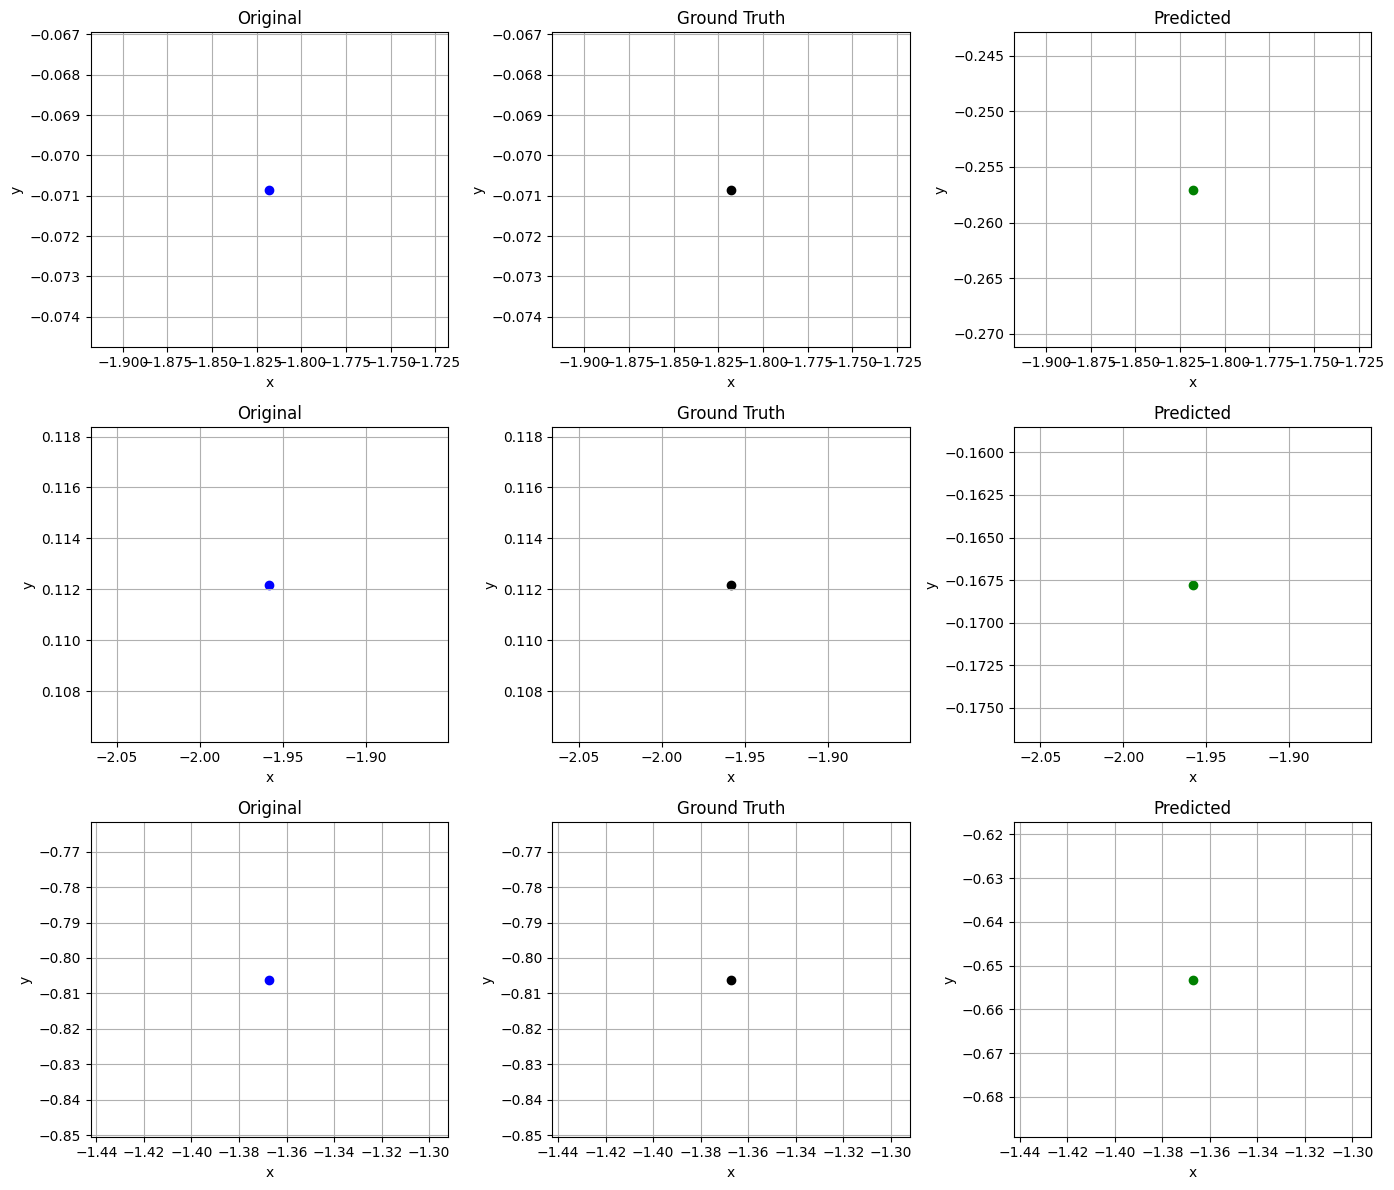

In [15]:
# -----------------------------
# 11. Predict and Visualize Results (Same Style as U-Net)
# -----------------------------

# Pick any 3 random test samples for display
idx = np.random.choice(len(X_test), 3, replace=False)

plt.figure(figsize=(14, 12))

for i, index in enumerate(idx):

    x_sample = X_test[index][0]
    y_true_sample = Y_test[index][0]
    y_pred_sample = model.predict(X_test[index].reshape(1,1))[0][0]

    # ----- ROW 1 : Original -----
    plt.subplot(3, 3, i*3 + 1)
    plt.scatter(x_sample, y_true_sample, color='blue')
    plt.title("Original")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)

    # ----- ROW 2 : Ground Truth -----
    plt.subplot(3, 3, i*3 + 2)
    plt.scatter(x_sample, y_true_sample, color='black')
    plt.title("Ground Truth")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)

    # ----- ROW 3 : Predicted -----
    plt.subplot(3, 3, i*3 + 3)
    plt.scatter(x_sample, y_pred_sample, color='green')
    plt.title("Predicted")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)

plt.tight_layout()
plt.show()
